In [92]:
from os import listdir
from os.path import isfile
import numpy as np
import json
import collections
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt

## Data Preparation

In [3]:
punch_path=r'D:\data\punch\punchout'
notpunch_path=r'D:\data\punch\notpunchout'
punch_fname=[f for f in listdir(punch_path) if isfile(os.path.join(punch_path, f))]
notpunch_fname=[f for f in listdir(notpunch_path) if isfile(os.path.join(notpunch_path, f))]

In [44]:
temporal_dim=10

In [45]:
def process_points_to_np(klist):
    new_list=[]
    for i in range(len(klist)):
        if i%3==0: #x
            if klist[i]==0:
                new_list.append(klist[i])
            else:
                new_list.append(klist[i]-klist[0])
        elif i%3 ==1:
            if klist[i]==0:
                new_list.append(klist[i])
            else:
                new_list.append(klist[i]-klist[1])
        else:
            continue
    return np.array(new_list)

In [46]:
def process_one_file(fpath,json_dir,temporal_dimension=10):
    fname=os.path.basename(fpath)
    fname=fname[:fname.rfind('.')]
    print(fname,json_dir)
    json_fname = [f for f in listdir(json_dir) if isfile(os.path.join(json_dir, f)) and f.startswith(fname)]
    #print(json_fname)
    if len(json_fname)==0:
        print('Warning: No json file found for '+fpath)
    d={}
    for o in json_fname:
        bar_pos=o.rfind('_')
        d[o]=int(o[bar_pos-12:bar_pos])
    ordered_json_fname=[k for k, v in sorted(d.items(), key=lambda item: item[1])]
    keypoints=[]
    for j in ordered_json_fname:
        jpath=os.path.join(json_dir, j)
        with open(jpath) as f:
            data = json.load(f)
        if len(data['people'])==0:
            keypoints.append(process_points_to_np([-999]*75))
        elif len(data['people'])==1:
            keypoints.append(process_points_to_np(data['people'][0]['pose_keypoints_2d']))
        else:
            if len(keypoints)==0:
                keypoints.append(process_points_to_np(data['people'][0]['pose_keypoints_2d']))
            else:
                minv=np.inf
                mini=0
                for k in range(len(data['people'])):
                    pts=process_points_to_np(data['people'][k]['pose_keypoints_2d'])
                    square_diff=np.square(pts-keypoints[-1]).sum()
                    if square_diff<minv:
                        minv=square_diff
                        mini=k
                keypoints.append(process_points_to_np(data['people'][mini]['pose_keypoints_2d']))

    point_buffer=collections.deque(maxlen=temporal_dimension)
    out_arr=None
    for i in range(temporal_dimension):
        point_buffer.append(keypoints[0])
    for i in range(len(keypoints)):
        point_buffer.append(keypoints[i])
        if out_arr is None:
            out_arr=np.expand_dims(np.stack(point_buffer,axis=0), axis=0)
        else:
            current_arr=np.expand_dims(np.stack(point_buffer,axis=0), axis=0)
            out_arr=np.concatenate([out_arr,current_arr],axis=0)
    return out_arr

In [47]:
test_size_per_class=3
Xpunch=None
for f in punch_fname[:-test_size_per_class]:
    if Xpunch is None:
        Xpunch=process_one_file(os.path.join(punch_path, f),os.path.join(punch_path, 'jsons'),temporal_dim)
    else:
        current_arr=process_one_file(os.path.join(punch_path, f),os.path.join(punch_path, 'jsons'),temporal_dim)
        Xpunch=np.concatenate([Xpunch,current_arr],axis=0)
Xpunch_test=None
for f in punch_fname[-test_size_per_class:]:
    if Xpunch_test is None:
        Xpunch_test=process_one_file(os.path.join(punch_path, f),os.path.join(punch_path, 'jsons'),temporal_dim)
    else:
        current_arr=process_one_file(os.path.join(punch_path, f),os.path.join(punch_path, 'jsons'),temporal_dim)
        Xpunch_test=np.concatenate([Xpunch_test,current_arr],axis=0)

-aOVo-6wAJw D:\data\punch\punchout\jsons
-oUA4Ki2VWA D:\data\punch\punchout\jsons
0hoO_olqi28 D:\data\punch\punchout\jsons
0ts6ui3-TNw D:\data\punch\punchout\jsons
0WQWIE_DllM D:\data\punch\punchout\jsons
0xT3I9lJEdA D:\data\punch\punchout\jsons
0ZaZz8idco8 D:\data\punch\punchout\jsons
1R33ibKMA0M D:\data\punch\punchout\jsons
2ovCxGPhG7M D:\data\punch\punchout\jsons
2TAYZ67B16E D:\data\punch\punchout\jsons
3FFl_DC2kIE D:\data\punch\punchout\jsons
3Kyz5dyPmE4 D:\data\punch\punchout\jsons
3lNdxrh1pKA D:\data\punch\punchout\jsons
4QyhLYasQj8 D:\data\punch\punchout\jsons
5DnpeHrTTuw D:\data\punch\punchout\jsons
5EwZkiyfmtY D:\data\punch\punchout\jsons
5KdLh4nP5XY D:\data\punch\punchout\jsons
5no6BywyCpg D:\data\punch\punchout\jsons
5_rNKmmbvC4 D:\data\punch\punchout\jsons
6LmrEYup_Vs D:\data\punch\punchout\jsons
6mXTqq7TlOk D:\data\punch\punchout\jsons
7Je4QGMVjUE D:\data\punch\punchout\jsons
7mT1Xd0Imvc D:\data\punch\punchout\jsons
7TLngTUG9BU D:\data\punch\punchout\jsons
7tu8gxbCUGE D:\d

In [48]:
test_size_per_class=3
Xnotpunch=None
for f in notpunch_fname[:-test_size_per_class]:
    if Xnotpunch is None:
        Xnotpunch=process_one_file(os.path.join(notpunch_path, f),os.path.join(notpunch_path, 'jsons'),temporal_dim)
    else:
        current_arr=process_one_file(os.path.join(notpunch_path, f),os.path.join(notpunch_path, 'jsons'),temporal_dim)
        Xnotpunch=np.concatenate([Xnotpunch,current_arr],axis=0)
Xnotpunch_test=None
for f in notpunch_fname[-test_size_per_class:]:
    if Xnotpunch_test is None:
        Xnotpunch_test=process_one_file(os.path.join(notpunch_path, f),os.path.join(notpunch_path, 'jsons'),temporal_dim)
    else:
        current_arr=process_one_file(os.path.join(notpunch_path, f),os.path.join(notpunch_path, 'jsons'),temporal_dim)
        Xnotpunch_test=np.concatenate([Xnotpunch_test,current_arr],axis=0)

a1 D:\data\punch\notpunchout\jsons
a2 D:\data\punch\notpunchout\jsons
a3 D:\data\punch\notpunchout\jsons
a4 D:\data\punch\notpunchout\jsons
v_BalanceBeam_g01_c04 D:\data\punch\notpunchout\jsons
v_BalanceBeam_g02_c01 D:\data\punch\notpunchout\jsons
v_BalanceBeam_g02_c02 D:\data\punch\notpunchout\jsons
v_Basketball_g03_c02 D:\data\punch\notpunchout\jsons
v_Basketball_g03_c03 D:\data\punch\notpunchout\jsons
v_Biking_g17_c04 D:\data\punch\notpunchout\jsons
v_Biking_g17_c05 D:\data\punch\notpunchout\jsons
v_Biking_g17_c06 D:\data\punch\notpunchout\jsons
v_BodyWeightSquats_g25_c02 D:\data\punch\notpunchout\jsons
v_BodyWeightSquats_g25_c03 D:\data\punch\notpunchout\jsons
v_BodyWeightSquats_g25_c04 D:\data\punch\notpunchout\jsons
v_HandStandPushups_g03_c01 D:\data\punch\notpunchout\jsons
v_HandStandPushups_g03_c02 D:\data\punch\notpunchout\jsons
v_HandStandPushups_g04_c02 D:\data\punch\notpunchout\jsons
v_HandStandPushups_g04_c03 D:\data\punch\notpunchout\jsons
v_HulaHoop_g02_c01 D:\data\punch

In [49]:
Xall=np.concatenate([Xpunch,Xnotpunch],axis=0)
yall=np.array([1]*Xpunch.shape[0]+[0]*Xnotpunch.shape[0])

In [50]:
yall.shape

(20679,)

In [51]:
X_train, X_val, y_train, y_val = train_test_split(Xall, yall, test_size=0.10, random_state=42)

In [52]:
X_train.shape

(18611, 10, 50)

In [113]:
X_val.shape

(2068, 10, 50)

## Model Training

In [41]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [53]:
input_shape=(temporal_dim, 50)
model = models.Sequential()
model.add(layers.LSTM(256, dropout=0.5,))
model.add(layers.Dense(2, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              #loss='hinge',
              metrics=['accuracy'])

In [54]:
history = model.fit(X_train, y_train, epochs=15, batch_size=16,
                    validation_data=(X_val, y_val))

Train on 18611 samples, validate on 2068 samples
Epoch 1/15
18611/18611 [==============================] - 12s 621us/sample - loss: 0.3448 - accuracy: 0.8445 - val_loss: 0.1623 - val_accuracy: 0.9434
Epoch 2/15
18611/18611 [==============================] - 6s 303us/sample - loss: 0.1637 - accuracy: 0.9396 - val_loss: 0.0931 - val_accuracy: 0.9681
Epoch 3/15
18611/18611 [==============================] - 6s 300us/sample - loss: 0.1228 - accuracy: 0.9564 - val_loss: 0.1466 - val_accuracy: 0.9405
Epoch 4/15
18611/18611 [==============================] - 6s 304us/sample - loss: 0.1020 - accuracy: 0.9629 - val_loss: 0.0796 - val_accuracy: 0.9749
Epoch 5/15
18611/18611 [==============================] - 6s 307us/sample - loss: 0.0975 - accuracy: 0.9640 - val_loss: 0.0772 - val_accuracy: 0.9729
Epoch 6/15
18611/18611 [==============================] - 6s 310us/sample - loss: 0.0924 - accuracy: 0.9664 - val_loss: 0.0897 - val_accuracy: 0.9676
Epoch 7/15
18611/18611 [==========================

In [112]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  multiple                  314368    
_________________________________________________________________
dense (Dense)                multiple                  514       
Total params: 314,882
Trainable params: 314,882
Non-trainable params: 0
_________________________________________________________________


## Model Testing

In [69]:
Xtest=np.concatenate([Xpunch_test,Xnotpunch_test],axis=0)

In [72]:
y_pred=model.predict_classes(Xtest)

In [73]:
y_true=[1]*Xpunch_test.shape[0]+[0]*Xnotpunch_test.shape[0]
accuracy_score(y_true, y_pred)

0.8115419296663661

In [75]:
model.save('proj6lstm')

INFO:tensorflow:Assets written to: proj6lstm\assets


In [65]:
ones

43

In [66]:
r.shape

(389, 2)

In [61]:
554/720

0.7694444444444445

## Generate Possibility Plot for Test Video

In [132]:
fname=punch_fname[-3]
X=process_one_file(os.path.join(punch_path, fname),os.path.join(punch_path, 'jsons'),temporal_dim)
y_pred=model.predict(X)
model.predict_classes(X)
json_out={}
result_list=[]
for i in range(y_pred.shape[0]):
    result_list.append([(i/30),y_pred[i,0]])
json_out["punch"]=result_list
with open('result/'+fname+'.json', 'w+') as outfile:
    json.dump(str(json_out), outfile)

v_Punch_g02_c01 D:\data\punch\punchout\jsons


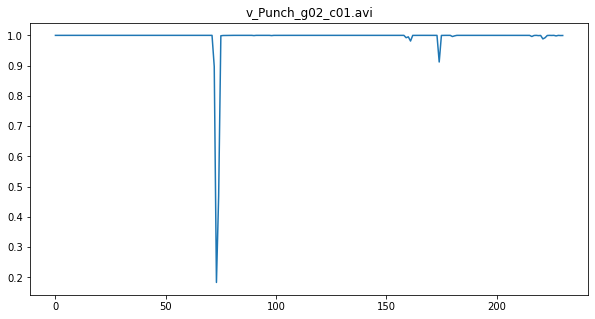

In [133]:
plt.figure(figsize=(10,5))
plt.plot(y_pred[:,1])
plt.title(fname)
plt.savefig('result/'+fname+'.png')

In [134]:
fname=punch_fname[-2]
X=process_one_file(os.path.join(punch_path, fname),os.path.join(punch_path, 'jsons'),temporal_dim)
y_pred=model.predict(X)
model.predict_classes(X)
json_out={}
result_list=[]
for i in range(y_pred.shape[0]):
    result_list.append([(i/30),y_pred[i,0]])
json_out["punch"]=result_list
with open('result/'+fname+'.json', 'w+') as outfile:
    json.dump(str(json_out), outfile)

v_Punch_g02_c02 D:\data\punch\punchout\jsons


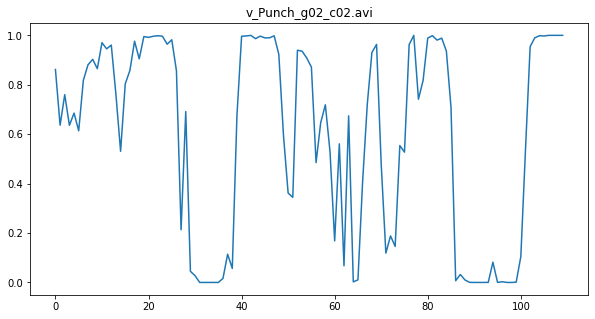

In [135]:
plt.figure(figsize=(10,5))
plt.plot(y_pred[:,1])
plt.title(fname)
plt.savefig('result/'+fname+'.png')

In [136]:
fname=punch_fname[-1]
X=process_one_file(os.path.join(punch_path, fname),os.path.join(punch_path, 'jsons'),temporal_dim)
y_pred=model.predict(X)
model.predict_classes(X)
json_out={}
result_list=[]
for i in range(y_pred.shape[0]):
    result_list.append([(i/30),y_pred[i,0]])
json_out["punch"]=result_list
with open('result/'+fname+'.json', 'w+') as outfile:
    json.dump(str(json_out), outfile)

v_Punch_g02_c03 D:\data\punch\punchout\jsons


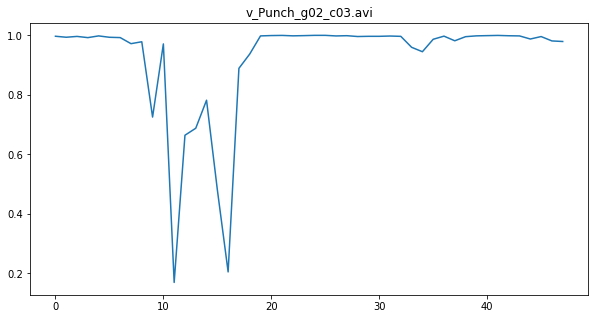

In [137]:
plt.figure(figsize=(10,5))
plt.plot(y_pred[:,1])
plt.title(fname)
plt.savefig('result/'+fname+'.png')

### Not punch

In [138]:
fname=notpunch_fname[-3]
X=process_one_file(os.path.join(notpunch_path, fname),os.path.join(notpunch_path, 'jsons'),temporal_dim)
y_pred=model.predict(X)
model.predict_classes(X)
json_out={}
result_list=[]
for i in range(y_pred.shape[0]):
    result_list.append([(i/30),y_pred[i,0]])
json_out["punch"]=result_list
with open('result/'+fname+'.json', 'w+') as outfile:
    json.dump(str(json_out), outfile)

v_WalkingWithDog_g14_c04 D:\data\punch\notpunchout\jsons


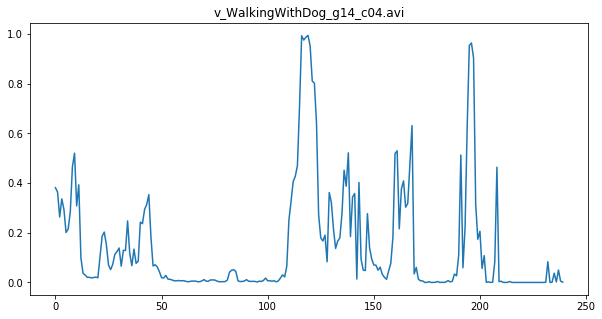

In [139]:
plt.figure(figsize=(10,5))
plt.plot(y_pred[:,1])
plt.title(fname)
plt.savefig('result/'+fname+'.png')

In [140]:
fname=notpunch_fname[-2]
X=process_one_file(os.path.join(notpunch_path, fname),os.path.join(notpunch_path, 'jsons'),temporal_dim)
y_pred=model.predict(X)
model.predict_classes(X)
json_out={}
result_list=[]
for i in range(y_pred.shape[0]):
    result_list.append([(i/30),y_pred[i,0]])
json_out["punch"]=result_list
with open('result/'+fname+'.json', 'w+') as outfile:
    json.dump(str(json_out), outfile)

v_WalkingWithDog_g17_c01 D:\data\punch\notpunchout\jsons


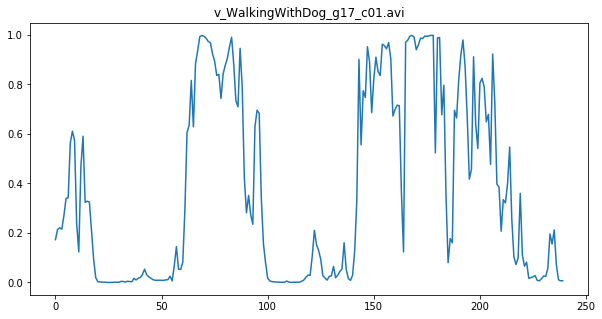

In [141]:
plt.figure(figsize=(10,5))
plt.plot(y_pred[:,1])
plt.title(fname)
plt.savefig('result/'+fname+'.png')

In [142]:
fname=notpunch_fname[-1]
X=process_one_file(os.path.join(notpunch_path, fname),os.path.join(notpunch_path, 'jsons'),temporal_dim)
y_pred=model.predict(X)
model.predict_classes(X)
json_out={}
result_list=[]
for i in range(y_pred.shape[0]):
    result_list.append([(i/30),y_pred[i,0]])
json_out["punch"]=result_list
with open('result/'+fname+'.json', 'w+') as outfile:
    json.dump(str(json_out), outfile)

v_WalkingWithDog_g17_c05 D:\data\punch\notpunchout\jsons


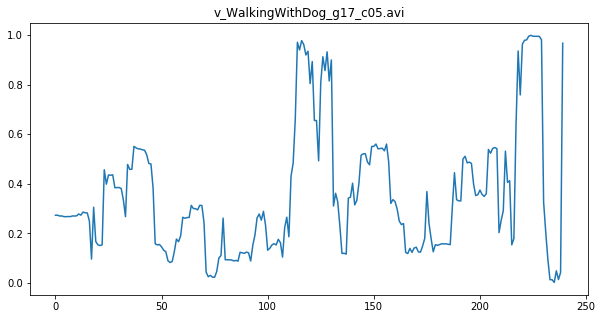

In [143]:
plt.figure(figsize=(10,5))
plt.plot(y_pred[:,1])
plt.title(fname)
plt.savefig('result/'+fname+'.png')

In [144]:
model.save_weights('./mw')